#  Data Augmentation

# Albumentations

In [1]:
!pip install albumentations

In [1]:
import os
import math
import random

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import albumentations as A

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2),  
            ])
    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            return img

In [3]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.fold = fold
        self.mode = mode
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        invalid_filnames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[-self.df['file_name'].isin(invalid_filnames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()
        
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    
    def __getitem__(self, idx):
        start = idx * self.batch_size
        final = (idx + 1) * self.batch_size
        data = self.df.iloc[start:final]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            
            image = cv2.imread(f'data/images/{file_name}.jpg') # f는 f-string 문자열 포매팅
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            if self.mode == 'train':
                image = image.astype('uint8')
                image = self.transform(image=image)
                
            image = image.astype('float32')
            image = image / 255.
        
            label = int(r['species']) - 1 # 고양이 1, 개 2 이므로 1 빼줌
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [4]:
csv_path = 'data/kfolds.csv'
train_generator = DataGenerator(
    fold=1,
    mode='train',
    csv_path=csv_path,
    batch_size=128,
    image_size=256,
    shuffle=True
)
valid_generator = DataGenerator(
    fold=1,
    mode='val',
    csv_path=csv_path,
    batch_size=128,
    image_size=256,
    shuffle=True
)

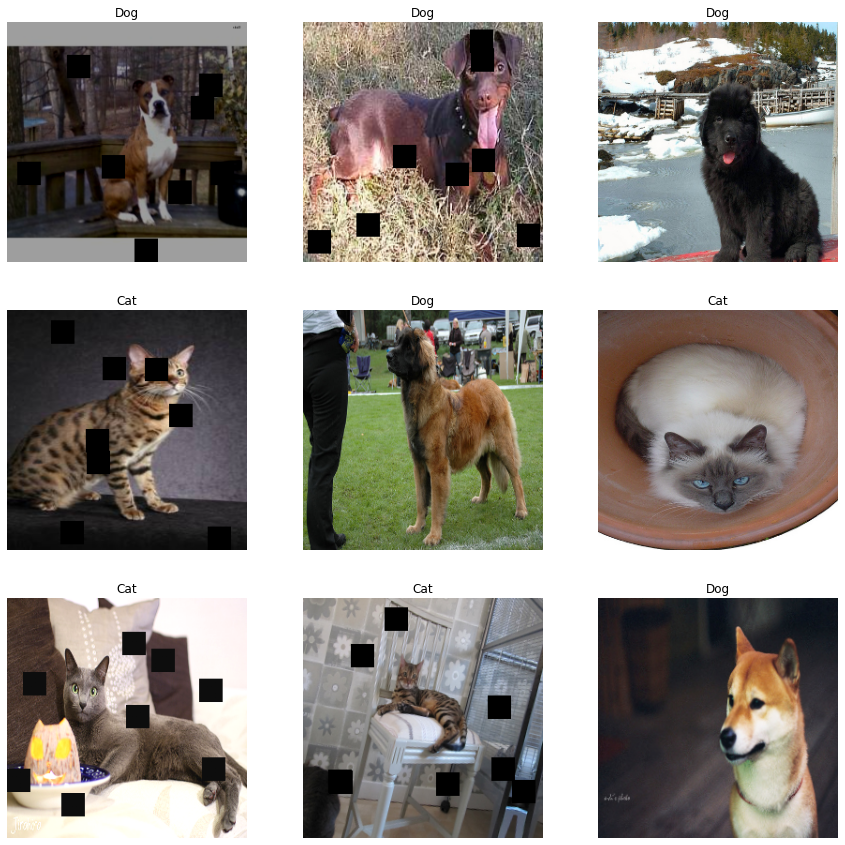

In [5]:
class_name = ['Cat', 'Dog']

for batch in train_generator:
    x, y = batch
    plt.figure(figsize=(15, 15))
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(x[i])
        plt.title(class_name[y[i]])
        plt.axis('off')
        
    break

In [6]:
def get_sequential_model(input_shape):
    model = keras.Sequential(
        [
            # Input
            layers.Input(input_shape),
            
            # 1st Conv block
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            
            # 2nd Conv block
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            
            # Classifier
            layers.GlobalMaxPool2D(),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ]
    )
    return model

input_shape = (256, 256, 3)
model = get_sequential_model(input_shape)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics='accuracy'
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     7

In [7]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10
46/46 [==============================] - 1169s 25s/step - loss: 0.9808 - accuracy: 0.6507 - val_loss: 0.6641 - val_accuracy: 0.6807
Epoch 2/10
46/46 [==============================] - 1186s 26s/step - loss: 0.6395 - accuracy: 0.6677 - val_loss: 0.6447 - val_accuracy: 0.6841
Epoch 3/10
46/46 [==============================] - 1192s 26s/step - loss: 0.6356 - accuracy: 0.6726 - val_loss: 0.6491 - val_accuracy: 0.6746
Epoch 4/10
46/46 [==============================] - 1202s 26s/step - loss: 0.6366 - accuracy: 0.6704 - val_loss: 0.6490 - val_accuracy: 0.6787
Epoch 5/10
46/46 [==============================] - 1194s 26s/step - loss: 0.6268 - accuracy: 0.6764 - val_loss: 0.6283 - val_accuracy: 0.6794
Epoch 6/10
46/46 [==============================] - 1202s 26s/step - loss: 0.6292 - accuracy: 0.6769 - val_loss: 0.6195 - val_accuracy: 0.6780
Epoch 7/10
46/46 [==============================] - 1197s 26s/step - loss: 0.6337 - accuracy: 0.6684 - val_loss: 0.6208 - val_accuracy: 0.6780